# Permute

### Import libraries

In [169]:
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms

### Config

In [230]:
batch_size = 512
path_net1 = 'checkpoint/net1/best.pth'
path_net2 = 'checkpoint/net2/best.pth'
path_net2_to_net1 = 'checkpoint/net2/net2_to_net1.pth'


In [171]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model Resnet20

In [174]:
def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, w=1, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = w*16

        self.conv1 = nn.Conv2d(3, w*16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(w*16)
        self.layer1 = self._make_layer(block, w*16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, w*32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, w*64, num_blocks[2], stride=2)
        self.linear = nn.Linear(w*64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet20(w=4):
    return ResNet(BasicBlock, [3, 3, 3], w=w)

In [175]:
def load(path):
    net = resnet20().to(device)
    state_dict = torch.load(path)['net']
    net.load_state_dict(state_dict)
    return net

net1 = load(path_net1)
net2 = load(path_net2)

### Dataset

In [176]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data/cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Evaluate models

In [177]:
# evaluates accuracy
def evaluate(model, loader=testloader):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            pred = outputs.argmax(dim=1)
            labels = labels.to(device)
            correct += (labels == pred).sum().item()
    return correct

# evaluates loss
def evaluate1(model, loader=testloader):
    model.eval()
    losses = []
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            loss = F.cross_entropy(outputs, labels.to(device))
            losses.append(loss.item())
    return np.array(losses).mean()

evaluate(net1)/100, evaluate(net2)/100

(95.81, 95.58)

### Code to compute correlation between weights

In [178]:
# given two networks net1, net2 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net1, net2, epochs=1, norm=True, loader=trainloader):
    n = epochs*len(loader)
    mean0 = mean1 = std1 = std2 = None
    with torch.no_grad():
        net1.eval()
        net2.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().to(device)
                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                out2 = net2(img_t)
                out2 = out2.reshape(out2.shape[0], out2.shape[1], -1).permute(0, 2, 1)
                out2 = out2.reshape(-1, out2.shape[2]).double()

                mean1_b = out1.mean(dim=0)
                mean2_b = out2.mean(dim=0)
                std1_b = out1.std(dim=0)
                std2_b = out2.std(dim=0)
                outer_b = (out1.T @ out2) / out1.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean1_b)
                    mean1 = torch.zeros_like(mean2_b)
                    std1 = torch.zeros_like(std1_b)
                    std2 = torch.zeros_like(std2_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean1_b / n
                mean1 += mean2_b / n
                std1 += std1_b / n
                std2 += std2_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    if norm:
        corr = cov / (torch.outer(std1, std2) + 1e-4)
        return corr
    else:
        return cov

### Code to find permutation mapping

In [179]:
def compute_perm_map(corr_mtx):
    # sort the (i, j) channel pairs by correlation
    nchan = corr_mtx.shape[0]
    triples = [(i, j, corr_mtx[i, j].item()) for i in range(nchan) for j in range(nchan)]
    triples = sorted(triples, key=lambda p: -p[2])
    # greedily find a matching
    perm_d = {}
    for i, j, c in triples:
        if not (i in perm_d.keys() or j in perm_d.values()):
            perm_d[i] = j
    perm_map = torch.tensor([perm_d[i] for i in range(nchan)])

    # qual_map will be a permutation of the indices in the order
    # of the quality / degree of correlation between the neurons found in the permutation.
    # this just for visualization purposes.
    qual_l = [corr_mtx[i, perm_map[i]].item() for i in range(nchan)]
    qual_map = torch.tensor(sorted(range(nchan), key=lambda i: -qual_l[i]))

    return perm_map, qual_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net1, net2, method='max_weight', vizz=False):
    def _get_layer_perm(corr_mtx, method='max_weight', vizz=False):
        if method == 'greedy':
            perm_map, qual_map = compute_perm_map(corr_mtx)
            if vizz:
                corr_mtx_viz = (corr_mtx[qual_map].T[perm_map[qual_map]]).T
                viz(corr_mtx_viz)
        elif method == 'max_weight':
            corr_mtx_a = corr_mtx.cpu().numpy()
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
            assert (row_ind == np.arange(len(corr_mtx_a))).all()
            perm_map = torch.tensor(col_ind).long()
        else:
            raise Exception('Unknown method: %s' % method)
            
        return perm_map
        
    corr_mtx = run_corr_matrix(net1, net2)
    return _get_layer_perm(corr_mtx, method, vizz)

### Code to apply permutations

In [180]:
# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, conv, bn):
    pre_weights = [
        conv.weight,
        bn.weight,
        bn.bias,
        bn.running_mean,
        bn.running_var,
    ]
    for w in pre_weights:
        w.data = w[perm_map]

# modifies the weight matrix of a convolution layer for a given
# permutation of the input channels
def permute_input(perm_map, after_convs):
    if not isinstance(after_convs, list):
        after_convs = [after_convs]
    post_weights = [c.weight for c in after_convs]
    for w in post_weights:
        w.data = w[:, perm_map, :, :]

### Apply on ResNet20

In [181]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        return x


perm_map = get_layer_perm(Subnet(net1), Subnet(net2))
permute_output(perm_map, net2.conv1, net2.bn1)
permute_output(perm_map, net2.layer1[0].conv2, net2.layer1[0].bn2)
permute_output(perm_map, net2.layer1[1].conv2, net2.layer1[1].bn2)
permute_output(perm_map, net2.layer1[2].conv2, net2.layer1[2].bn2)
permute_input(perm_map, [net2.layer1[0].conv1, net2.layer1[1].conv1, net2.layer1[2].conv1])
permute_input(perm_map, [net2.layer2[0].conv1, net2.layer2[0].shortcut[0]])

100%|██████████| 98/98 [00:14<00:00,  6.63it/s]


In [182]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        return x

perm_map = get_layer_perm(Subnet(net1), Subnet(net2))
permute_output(perm_map, net2.layer2[0].conv2, net2.layer2[0].bn2)
permute_output(perm_map, net2.layer2[0].shortcut[0], net2.layer2[0].shortcut[1])
permute_output(perm_map, net2.layer2[1].conv2, net2.layer2[1].bn2)
permute_output(perm_map, net2.layer2[2].conv2, net2.layer2[2].bn2)

permute_input(perm_map, [net2.layer2[1].conv1, net2.layer2[2].conv1])
permute_input(perm_map, [net2.layer3[0].conv1, net2.layer3[0].shortcut[0]])

100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


In [183]:
class Subnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        self = self.model
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

perm_map = get_layer_perm(Subnet(net1), Subnet(net2))
permute_output(perm_map, net2.layer3[0].conv2, net2.layer3[0].bn2)
permute_output(perm_map, net2.layer3[0].shortcut[0], net2.layer3[0].shortcut[1])
permute_output(perm_map, net2.layer3[1].conv2, net2.layer3[1].bn2)
permute_output(perm_map, net2.layer3[2].conv2, net2.layer3[2].bn2)

permute_input(perm_map, [net2.layer3[1].conv1, net2.layer3[2].conv1])
net2.linear.weight.data = net2.linear.weight[:, perm_map]

100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


In [184]:
class Subnet(nn.Module):
    def __init__(self, model, nb=9):
        super().__init__()
        self.model = model
        self.blocks = []
        self.blocks += list(model.layer1)
        self.blocks += list(model.layer2)
        self.blocks += list(model.layer3)
        self.blocks = nn.Sequential(*self.blocks)
        self.bn1 = model.bn1
        self.conv1 = model.conv1
        self.linear = model.linear
        self.nb = nb
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.blocks[:self.nb](x)
        block = self.blocks[self.nb]
        x = block.conv1(x)
        x = block.bn1(x)
        x = F.relu(x)
#         x = F.avg_pool2d(x, x.size()[3])
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
        return x

blocks1 = []
blocks1 += list(net2.layer1)
blocks1 += list(net2.layer2)
blocks1 += list(net2.layer3)
blocks1 = nn.Sequential(*blocks1)

In [185]:
for nb in range(9):
    perm_map = get_layer_perm(Subnet(net1, nb=nb), Subnet(net2, nb=nb))
    block = blocks1[nb]
    permute_output(perm_map, block.conv1, block.bn1)
    permute_input(perm_map, [block.conv2])

100%|██████████| 98/98 [00:26<00:00,  3.66it/s]


In [186]:
print('Saving permuted model..')
state = {'net': net2.state_dict()}
torch.save(state, path_net2_to_net1)

Saving permuted model..


### Evaluate the interpolated network

In [187]:
def mix_weights(model, alpha, path1, path2):
    sd0 = torch.load(path1)['net']
    sd1 = torch.load(path2)['net']
    sd_alpha = {k: (1 - alpha) * sd0[k].to(device) + alpha * sd1[k].to(device)
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1, loader=trainloader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images.to(device))

### Visualization

In [229]:
model_a = resnet20(4).to(device)
nb_steps = 30
alphas = np.linspace(0,1,nb_steps)

In [204]:
loss_net1_net2 = []
loss_net1_net2perm = []
acc_net1_net2 = []
acc_net1_net2perm = []
for alpha in tqdm(alphas):
    # net1 => net2
    mix_weights(model_a, alpha, path_net1, path_net2)
    reset_bn_stats(model_a)
    loss_net1_net2 += [evaluate1(model_a)]
    acc_net1_net2 += [evaluate(model_a)/100]
    # net1 => net2perm
    mix_weights(model_a, alpha, path_net1, path_net2_to_net1)
    reset_bn_stats(model_a)
    loss_net1_net2perm += [evaluate1(model_a)]
    acc_net1_net2perm += [evaluate(model_a)/100]

100%|██████████| 30/30 [11:27<00:00, 22.93s/it]


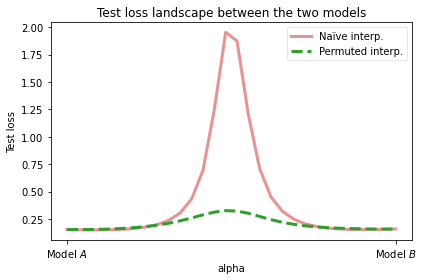

In [228]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alphas,
        loss_net1_net2,
        linestyle="solid",
        color="tab:red",
        alpha=0.5,
        linewidth=3,
        label="Naïve interp.")
ax.plot(alphas,
        loss_net1_net2perm,
        linestyle="dashed",
        color="tab:green",
        linewidth=3,
        label="Permuted interp.")
ax.set_xlabel("alpha")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Model $A$", "Model $B$"])
ax.set_ylabel("Test loss")
ax.set_title(f"Test loss landscape between the two models")
ax.legend(loc="upper right", framealpha=0.5)
fig.tight_layout()

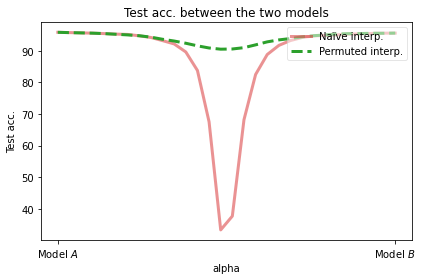

In [231]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alphas,
        acc_net1_net2,
        linestyle="solid",
        color="tab:red",
        alpha=0.5,
        linewidth=3,
        label="Naïve interp.")
ax.plot(alphas,
        acc_net1_net2perm,
        linestyle="dashed",
        color="tab:green",
        linewidth=3,
        label="Permuted interp.")
ax.set_xlabel("alpha")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Model $A$", "Model $B$"])
ax.set_ylabel("Test acc.")
ax.set_title(f"Test acc. between the two models")
ax.legend(loc="upper right", framealpha=0.5)
fig.tight_layout()